<a href="https://colab.research.google.com/github/Bishara10/EEG-Classification/blob/main/EEG_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Prerequisites


In [2]:
!git clone https://github.com/BPy5/ML-Classification-model-For-EEG-Recordings.git

fatal: destination path 'ML-Classification-model-For-EEG-Recordings' already exists and is not an empty directory.


In [3]:
import os

import numpy as np
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.signal import resample, butter, filtfilt, welch
from scipy.stats import pearsonr


%matplotlib notebook
%matplotlib inline


# Preprocess dataset

### Load Data

In [4]:
file_names_adhd_dataset = ['v8p.csv', 'v35p.csv', 'v37p.csv', 'v36p.csv', 'v38p.csv', 'v6p.csv', 'v40p.csv', 'v39p.csv', 'v3p.csv', 'v29p.csv', 'v30p.csv', 'v31p.csv', 'v28p.csv', 'v279.csv', 'v33p.csv', 'v25p.csv', 'v286.csv', 'v250.csv', 'v24p.csv', 'v246.csv', 'v263.csv', 'v27p.csv', 'v254.csv', 'v284.csv', 'v238.csv', 'v265.csv', 'v227.csv', 'v215.csv', 'v236.csv', 'v22p.csv', 'v21p.csv', 'v231.csv', 'v244.csv', 'v213.csv', 'v274.csv', 'v200.csv', 'v206.csv', 'v19p.csv', 'v173.csv', 'v270.csv', 'v234.csv', 'v179.csv', 'v181.csv', 'v18p.csv', 'v14p.csv', 'v196.csv', 'v209.csv', 'v183.csv', 'v12p.csv', 'v219.csv', 'v15p.csv', 'v20p.csv', 'v198.csv', 'v190.csv', 'v1p.csv', 'v32p.csv', 'v177.csv', 'v10p.csv', 'v34p.csv', 'v288.csv', 'v204.csv']
# print(len(file_names_adhd_dataset))
file_names_control_dataset = ['v51p.csv', 'v59p.csv', 'v304.csv', 'v45p.csv', 'v54p.csv', 'v58p.csv', 'v53p.csv', 'v60p.csv', 'v56p.csv', 'v46p.csv', 'v308.csv', 'v42p.csv', 'v43p.csv', 'v306.csv', 'v48p.csv', 'v50p.csv', 'v52p.csv', 'v302.csv', 'v44p.csv', 'v47p.csv', 'v307.csv', 'v57p.csv', 'v303.csv', 'v127.csv', 'v134.csv', 'v121.csv', 'v299.csv', 'v151.csv', 'v116.csv', 'v125.csv', 'v133.csv', 'v300.csv', 'v147.csv', 'v298.csv', 'v113.csv', 'v118.csv', 'v117.csv', 'v120.csv', 'v111.csv', 'v107.csv', 'v114.csv', 'v108.csv', 'v115.csv', 'v305.csv', 'v140.csv', 'v149.csv', 'v309.csv', 'v123.csv', 'v138.csv', 'v112.csv', 'v41p.csv', 'v129.csv', 'v143.csv', 'v310.csv', 'v131.csv', 'v297.csv', 'v109.csv', 'v49p.csv', 'v55p.csv', 'v110.csv']
# print(len(file_names_control_dataset))

pathControl = '/content/ML-Classification-model-For-EEG-Recordings/Dataset/CSV/controlcsv/'
pathADHD = '/content/ML-Classification-model-For-EEG-Recordings/Dataset/CSV/adhdcsv/'
outputPath = '/content/preprocessed_dataset/'

### Functions for preprocessing
Downsampling: to redude the number of samples in the given data.
BandPassFilter to filter signal noise.
Preprocess_file: preprocesses a single file.
Preprocess_group: preprocess and save all files to a corresponding group folder.

In [5]:
# Preprocessed dataset
dataADHD = []
dataControl = []

# parameters for bandpass filter
lowcut = 1.0  # Hz
highcut = 40.0  # Hz

# Set parameters
original_fs = 128  # Sampling frequency in Hz
target_fs = 64  # Target sampling frequency in Hz
nperseg = 128  # Number of samples per segment
noverlap = 64  # Number of overlapping samples (typically half of nperseg)


In [6]:
# filter channel and reduce noise.
def bandPassFilter(signal):
    fs = 4000.0

    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    order = 2
    b, a = scipy.signal.butter(order, [low, high], 'bandpass', analog=False)
    # print(f"Applying bandpass filter: lowcut={lowcut} Hz, highcut={highcut} Hz, fs={fs} Hz")
    # print(f"Normalized frequencies: low={low}, high={high}")
    y = scipy.signal.filtfilt(b, a, signal, axis=0)

    return y

In [7]:
# Compute Pearson correlation features
def pearson_correlation_two_signals(signal1, signal2):
  statistic, pvalue = pearsonr(signal1, signal2)

  return statistic, pvalue

In [8]:
def calculate_psd(signal, fs=128):
    # Welch's method to estimate PSD
    freqs, psd = welch(signal, fs=fs, nperseg=256)
    return psd

In [9]:
# Function to downsample the signal
def downsample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    # print(f"Original signal length: {len(signal)}, Downsampled signal length: {num_samples}")
    return resample(signal, num_samples)

In [10]:
# Preprocessing for an entire recording for a patient
def preprocess_file(input_file, group_category):
  df = pd.read_csv(input_file)
  new_signals = []
  pearson_cors = []

  for column in df.columns:
    signal = df[column].values
    downsampled_signal = downsample_signal(signal, original_fs, target_fs)
    filtered_signal = bandPassFilter(downsampled_signal)
    new_signals.append(filtered_signal)

  for signal in range(len(new_signals) - 1):
    for next_signal in range(len(new_signals)):
      corr, _ = pearson_correlation_two_signals(new_signals[signal], new_signals[next_signal])
      pearson_cors.append(corr)

  if group_category == 'ADHD':
    dataADHD.append(pearson_cors)
  elif group_category == 'CONTROL':
    dataControl.append(pearson_cors)
    # # Calculate PSD for each channel
    # for signal in new_signals:
    #     psd = calculate_psd(signal)
    #     psd_features.extend(psd)  # Combine PSD values into one feature vector

In [11]:
# Preprocess all recordings for a specific group
def preprocess_group(group_path, group_file_names, output_path, group_category):
  i = 1
  for filename in group_file_names:
    file_name_and_path = group_path + filename;
    print(filename + ' data preprocessed ' + str(i) + '/' + str(len(group_file_names)))
    preprocess_file(file_name_and_path, group_category)
    i += 1
  print("=============================== Preprocessing group " + group_category + " successful =============================== ")

In [12]:
# # Calculate the maximum time bins across all files
# def calculate_max_time_bins(files):
#     max_time_bins = 0
#     for file in files:
#         df = pd.read_csv(file)
#         for column in df.columns:
#             signal = df[column].values
#             downsampled_signal = downsample_signal(signal, original_fs, target_fs)
#             f, t, Sxx = spectrogram(downsampled_signal, fs=target_fs, nperseg=nperseg, noverlap=noverlap)
#             max_time_bins = max(max_time_bins, Sxx.shape[1])
#     return max_time_bins


In [13]:
filesADHD = ['/content/ML-Classification-model-For-EEG-Recordings/Dataset/CSV/adhdcsv/' + x for x in file_names_adhd_dataset]
filesControl = ['/content/ML-Classification-model-For-EEG-Recordings/Dataset/CSV/controlcsv/' + x for x in file_names_control_dataset]

# Find max time bin
# x = calculate_max_time_bins(filesADHD)
# y = calculate_max_time_bins(filesControl)
# maxTimeBins = max(x, y)


# preprocess groups
preprocess_group(pathADHD, file_names_adhd_dataset, outputPath + '/ADHD/', 'ADHD')
preprocess_group(pathControl, file_names_control_dataset, outputPath + '/Control/', 'CONTROL')


v8p.csv data preprocessed 1/61
v35p.csv data preprocessed 2/61
v37p.csv data preprocessed 3/61
v36p.csv data preprocessed 4/61
v38p.csv data preprocessed 5/61
v6p.csv data preprocessed 6/61
v40p.csv data preprocessed 7/61
v39p.csv data preprocessed 8/61
v3p.csv data preprocessed 9/61
v29p.csv data preprocessed 10/61
v30p.csv data preprocessed 11/61
v31p.csv data preprocessed 12/61
v28p.csv data preprocessed 13/61
v279.csv data preprocessed 14/61
v33p.csv data preprocessed 15/61
v25p.csv data preprocessed 16/61
v286.csv data preprocessed 17/61
v250.csv data preprocessed 18/61
v24p.csv data preprocessed 19/61
v246.csv data preprocessed 20/61
v263.csv data preprocessed 21/61
v27p.csv data preprocessed 22/61
v254.csv data preprocessed 23/61
v284.csv data preprocessed 24/61
v238.csv data preprocessed 25/61
v265.csv data preprocessed 26/61
v227.csv data preprocessed 27/61
v215.csv data preprocessed 28/61
v236.csv data preprocessed 29/61
v22p.csv data preprocessed 30/61
v21p.csv data preproce

In [14]:
len(dataADHD)

61

In [15]:
len(dataControl)

60

# Clustering: Kmeans

In [16]:
# Convert the lists into numpy arrays
X_adhd = np.array(dataADHD)
X_control = np.array(dataControl)

# Combine ADHD and contol data
X = np.vstack((X_adhd, X_control))

# Create the label vector (1 for ADHD, 0 for control)
y = np.array([1] * len(X_adhd) + [0] * len(X_control))

<ipython-input-17-12c07ef6b2f4>:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:, 0], X_pca[:, 1], s=40, cmap='viridis')


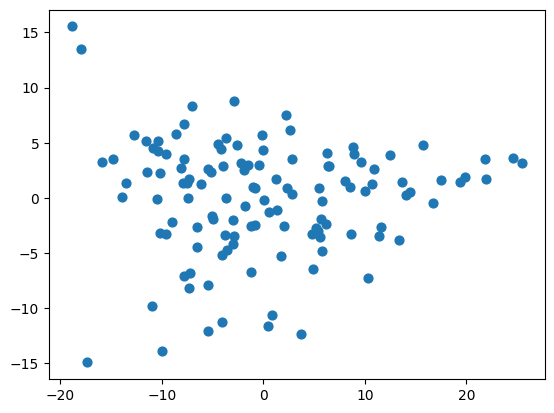

In [17]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


plt.scatter(X_pca[:, 0], X_pca[:, 1], s=40, cmap='viridis')
plt.show()


In [18]:
# Initialize the KMeans model with 2 clusters (ADHD and Control)
kmeans = KMeans(n_clusters=2, n_init=12, random_state=42)

# Fit the model to the data
kmeans.fit(X_pca)

KMeans(n_clusters=2, n_init=12, random_state=42)

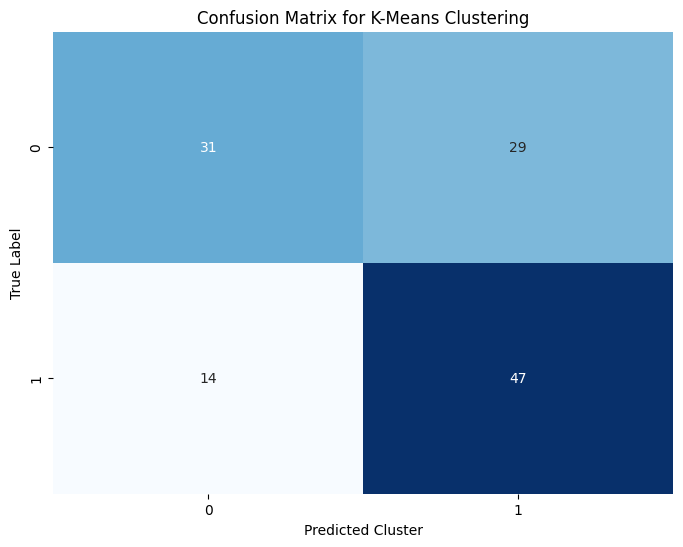

Silhouette Score for K-Means clustering: 0.16


In [19]:
# Create a confusion matrix to compare actual labels with cluster labels
cluster_labels = kmeans.predict(X_pca)
cm = confusion_matrix(y, cluster_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Cluster")
plt.ylabel("True Label")
plt.title("Confusion Matrix for K-Means Clustering")
plt.show()


# Predict cluster labels for the data
cluster_labels = kmeans.predict(X_pca)

silhouette_avg = silhouette_score(X_scaled, cluster_labels)

print(f"Silhouette Score for K-Means clustering: {silhouette_avg:.2f}")


In [20]:
# Extract True Positives, True Negatives, False Positives, and False Negatives
TN, FP, FN, TP = cm.ravel()

# Calculate metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall (Sensitivity): {recall:.2f}")
print(f"Specificity: {specificity:.2f}")

Accuracy: 0.64
Precision: 0.62
Recall (Sensitivity): 0.77
Specificity: 0.52


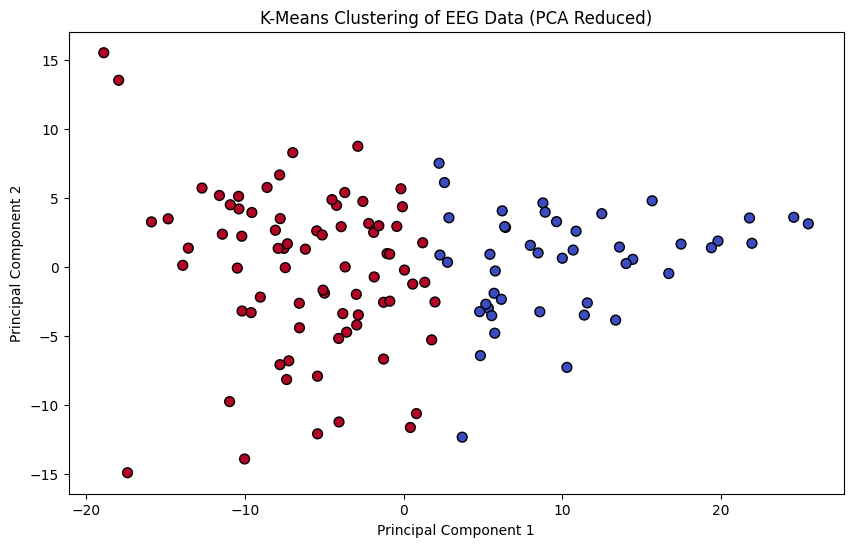

In [21]:
predicted = kmeans.predict(X_pca)

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='coolwarm', edgecolor='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering of EEG Data (PCA Reduced)')
plt.show()

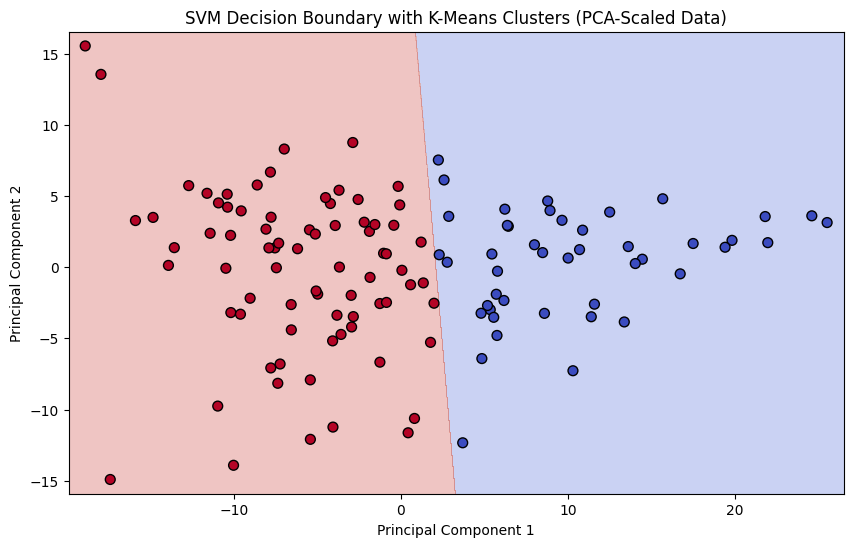

In [25]:
# Step 3: Split the pca-scaled data
X_train, X_test, y_train, y_test = train_test_split(X_pca, cluster_labels, test_size=0.2, random_state=42)

# Step 4: Train an SVM model on the original scaled data
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)

# Step 5: Predict on the test set
y_pred = svm_classifier.predict(X_test)

# Step 6: Evaluate and visualize (Optional: use PCA for visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Predict the SVM decision boundary using the full feature set (342 features)
h = .02  # Step size in the mesh
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = svm_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='coolwarm', edgecolor='k', s=50)
plt.title("SVM Decision Boundary with K-Means Clusters (PCA-Scaled Data)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [48]:
data = np.array(dataControl[8])

reshaped_data = data.reshape(1, -1)
reshaped_data_scaled = scaler.transform(reshaped_data)
pca_transformed_data = pca.transform(reshaped_data_scaled)

pred = svm_classifier.predict(pca_transformed_data)
print(pred)

[1]
